In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from collections import defaultdict
import matplotlib.ticker as ticker
import glob
import os
import pickle
import sys
sys.path.append("/scratch/halmazan//WCTE/WCTECoincidence_Analysis/Complete_analysis")

from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

In [2]:
def deltaR(df):
    # Ensure numeric columns (coerce any stray strings/lists)
    cols = ["prompt_x","prompt_y","prompt_z","delayed_x","delayed_y","delayed_z"]
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Build position arrays
    p = df[["prompt_x","prompt_y","prompt_z"]].to_numpy()
    d = df[["delayed_x","delayed_y","delayed_z"]].to_numpy()

    # Radii from origin
    df["prompt_r"] = np.linalg.norm(p, axis=1)
    df["delayed_r"] = np.linalg.norm(d, axis=1)

    # DeltaR: 3D distance between prompt and delayed vertices
    df["DeltaR"] = np.abs(df["delayed_r"] - df["prompt_r"])

def deltaT(df):
    # DeltaT: Time difference between prompt and delayed vertices
    df["DeltaT"] = np.abs(df["delayed_time"]/1000 - df["prompt_time"]/1000)

def exp_func(x, A, tau):
    return A * np.exp(-x / tau)

In [3]:
#Runs to compare 
sig_run = '2386'
pos = [0.0, 0.0, -30.5]
bkg_run = '2384'

if sig_run == '2385':
    pos = [0.0, 0.0, -30.5]
elif sig_run == '2386':
    pos = [0.0, 0.0, +30.5]
elif sig_run == '2387':
    pos = [.0, 0.0, +58.5]
elif sig_run == '2388':
    post = [35.3553, -35.3553, -30.5]
elif sig_run == '2389':
    pos = [-35.3553, 35.3553, +30.5]


prompt_window = 1500  # Window for prompt candidates
prompt_dead_time = 200  # Death time for prompt candidates
prompt_t_rms_min = 200
prompt_t_rms_max = 400
prompt_nhits_min = 150
prompt_nhits_max = 300
coincidence_window = 150000  # Window for coincidence search
delayed_window = 100  # Window for delayed candidates
delayed_nhits_min = 10  # Minimum number of hits for delayed candidates
delayed_nhits_max = 30  # Maximum number of hits for delayed candidates

In [4]:
bkg_file = f'/scratch/halmazan/WCTE/files/data/AmBeCandidates/neutron_candidates_{bkg_run}_timestest.csv'
sig_file = f'/scratch/halmazan/WCTE/files/data/AmBeCandidates/neutron_candidates_{sig_run}_timestest.csv'
df = pd.read_csv(sig_file)
df_bkg = pd.read_csv(bkg_file)

deltaR(df)
deltaR(df_bkg)

deltaT(df)
deltaT(df_bkg)

In [5]:
df['prompt_id'] = df.groupby(['prompt_nhits', 'prompt_time']).cumcount()
cols = ['prompt_id'] + [col for col in df.columns if col != 'prompt_id']
df = df[cols]

df_bkg['prompt_id'] = df_bkg.groupby(['prompt_nhits', 'prompt_time']).cumcount()
cols = ['prompt_id'] + [col for col in df_bkg.columns if col != 'prompt_id']
df_bkg = df_bkg[cols]

In [7]:
mean_x = np.mean(df['delayed_x'])
mean_y = np.mean(df['delayed_y'])
mean_z = np.mean(df['delayed_z'])

error_of_mean_x = np.std(df['delayed_x'], ddof=1) / np.sqrt(len(df['delayed_x']))
error_of_mean_y = np.std(df['delayed_y'], ddof=1) / np.sqrt(len(df['delayed_y']))
error_of_mean_z = np.std(df['delayed_z'], ddof=1) / np.sqrt(len(df['delayed_z']))

print(f"Mean X: {mean_x:.2f} ± {error_of_mean_x:.2f} cm, position: {pos[0]} cm")
print(f"Mean Y: {mean_y:.2f} ± {error_of_mean_y:.2f} cm, position: {pos[1]} cm")
print(f"Mean Z: {mean_z:.2f} ± {error_of_mean_z:.2f} cm, position: {pos[2]} cm")

Mean X: -5.89 ± 3.48 cm, position: 0.0 cm
Mean Y: 4.72 ± 3.37 cm, position: 0.0 cm
Mean Z: 18.04 ± 3.54 cm, position: 30.5 cm


In [6]:
idx = df.groupby(['prompt_time', 'prompt_nhits'])['delayed_nhits'].idxmax()
df_filtered = df.loc[idx].reset_index(drop=True)
df = df_filtered

idx_bkg = df_bkg.groupby(['prompt_time', 'prompt_nhits'])['delayed_nhits'].idxmax()
df_filtered_bkg = df_bkg.loc[idx_bkg].reset_index(drop=True)
df_bkg = df_filtered_bkg

#df_max_delayed_nhits_bkg = df_bkg.loc[df_bkg.groupby('event_number')['delayed_nhits'].idxmax()]
#df_bkg = df_max_delayed_nhits_bkg

In [8]:
R = np.sqrt(
    (df['delayed_x'] - mean_x) ** 2 +
    (df['delayed_y'] - mean_y) ** 2 +
    (df['delayed_z'] - mean_z) ** 2
)
cut_mask = R < 60
df_selected = df[cut_mask]

df_selected = df[cut_mask].copy()
df_selected['R'] = R[cut_mask]

In [9]:
df_selected

,prompt_id,prompt_nhits,prompt_time,prompt_trms,prompt_x,prompt_y,prompt_z,delayed_time,delayed_nhits,delayed_x,delayed_y,delayed_z,prompt_r,delayed_r,DeltaR,DeltaT,R
4,0,261,5.563807e+09,259.880346,169.671234,132.629456,-235.157486,5.563830e+09,22,-14.430691,-19.918678,3.757387,318.869791,24.882053,293.987738,23.004705,29.737693
9,0,209,5.801350e+09,265.063824,25.561117,2.260818,157.620651,5.801351e+09,29,15.592698,22.823616,50.070740,159.695810,57.193782,102.502028,1.543006,42.600585
16,0,182,2.547970e+10,336.798413,-60.693291,-141.924927,-107.167152,2.547970e+10,29,-22.152317,26.836107,57.515663,187.912636,67.223161,120.689476,5.259030,48.080407
24,0,223,2.555712e+10,314.759674,-142.118576,-58.277363,80.913345,2.555712e+10,29,-26.859919,-31.541525,-19.838606,173.611377,45.933575,127.677802,4.724196,56.480191
35,0,166,2.576652e+10,298.392862,88.027451,192.413101,-4.537304,2.576655e+10,29,-13.163162,14.023670,16.110224,211.641727,25.089270,186.552457,27.915051,11.964580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,0,237,1.325774e+12,305.632072,-172.691925,-191.276978,-158.933304,1.325774e+12,29,-9.075675,23.166943,1.277660,302.769183,24.914003,277.855180,14.376061,25.125783
1011,0,153,1.325860e+12,334.676113,4.128825,161.006714,-147.400467,1.325860e+12,29,26.414951,13.625452,42.563301,218.327980,51.913748,166.414232,111.693264,41.520238
1013,1,154,1.325878e+12,215.223039,22.263161,-82.881523,113.333511,1.325878e+12,29,-7.740266,-3.580771,-21.129807,142.160051,22.786013,119.374038,76.849711,40.084765
1022,0,175,1.345574e+12,266.609012,160.746964,-44.259621,66.928543,1.345574e+12,20,-17.799089,-18.528854,31.236534,179.660597,40.445607,139.214991,1.500211,29.270415


In [11]:
N_events_sig = 109982
N_events_bkg = 155893

N_events_sel_sig = len(df["prompt_id"])
N_events_sel_bkg = len(df_bkg["prompt_id"])  #df_bkg["event_number"].nunique() 

print("Events Signal", N_events_sel_sig)
print("Events Bkg", N_events_sel_bkg)

print("Signal Events/Second", N_events_sel_sig/(N_events_sig*270*1e-6))
print("Bkg Events/Second", N_events_sel_bkg/(N_events_bkg*270*1e-6))

print("Candidate events/Second", N_events_sel_sig/(N_events_sig*270*1e-6) - N_events_sel_bkg/(N_events_bkg*270*1e-6))


# Count entries per event_number
#event_counts = df['event_number'].value_counts()

# Number of events with more than one entry
#num_events_multiple_entries = (event_counts > 1).sum()
#print(f"Number of events with more than one entry: {num_events_multiple_entries}")

Events Signal 1030
Events Bkg 207
Signal Events/Second 34.68581054004123
Bkg Events/Second 4.917903091650469
Candidate events/Second 29.767907448390762


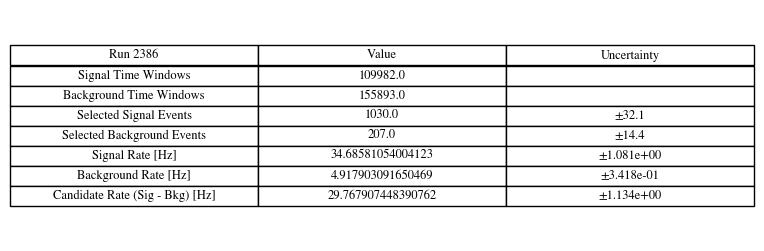

In [13]:
window_time = 270e-6  # seconds per time window

# --- Compute rates ---
rate_sig = N_events_sel_sig / (N_events_sig * window_time)
rate_bkg = N_events_sel_bkg / (N_events_bkg * window_time)
rate_diff = rate_sig - rate_bkg

# --- Statistical uncertainties ---
# Poisson error for counts
err_N_sig = np.sqrt(N_events_sel_sig)
err_N_bkg = np.sqrt(N_events_sel_bkg)

# propagate to rates: rate = N_sel / (N_total * window_time)
err_rate_sig = err_N_sig / (N_events_sig * window_time)
err_rate_bkg = err_N_bkg / (N_events_bkg * window_time)

# difference uncertainty (assuming independence)
err_rate_diff = np.sqrt(err_rate_sig**2 + err_rate_bkg**2)

# --- Create summary table ---
results = {
    f"Run {sig_run}": [
        "Signal Time Windows",
        "Background Time Windows",
        "Selected Signal Events",
        "Selected Background Events",
        "Signal Rate [Hz]",
        "Background Rate [Hz]",
        "Candidate Rate (Sig - Bkg) [Hz]",
    ],
    "Value": [
        N_events_sig,
        N_events_bkg,
        N_events_sel_sig,
        N_events_sel_bkg,
        rate_sig,
        rate_bkg,
        rate_diff,
    ],
    "Uncertainty": [
        "",  # time windows: no Poisson error
        "",
        f"±{err_N_sig:.1f}",
        f"±{err_N_bkg:.1f}",
        f"±{err_rate_sig:.3e}",
        f"±{err_rate_bkg:.3e}",
        f"±{err_rate_diff:.3e}",
    ]
}

df_results = pd.DataFrame(results)

# Show nicely
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,3))
ax.axis('off')
tbl = ax.table(
    cellText=df_results.values,
    colLabels=df_results.columns,
    loc='center',
    cellLoc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1.2, 1.2)

plt.show()


In [14]:
df

,prompt_id,prompt_nhits,prompt_time,prompt_trms,prompt_x,prompt_y,prompt_z,delayed_time,delayed_nhits,delayed_x,delayed_y,delayed_z,prompt_r,delayed_r,DeltaR,DeltaT
0,1,215,5.430911e+09,224.754683,27.825008,-26.006439,105.636604,5.431047e+09,29,-152.717529,56.698921,62.029957,112.292734,174.313301,62.020567,135.640446
1,0,198,5.464951e+09,212.441503,-115.993393,-205.113663,158.634613,5.464952e+09,13,-50.269352,-143.142410,15.523750,284.061652,152.504899,131.556753,1.514243
2,1,262,5.558531e+09,200.336731,145.636688,30.866497,-108.289581,5.558627e+09,14,-165.267883,41.123940,-114.201630,184.090790,205.052832,20.962042,96.326377
3,0,201,5.563682e+09,268.970094,-248.441711,68.455147,-189.578613,5.563807e+09,29,-153.655777,15.722279,-155.748932,319.920993,219.351357,100.569636,124.995384
4,0,261,5.563807e+09,259.880346,169.671234,132.629456,-235.157486,5.563830e+09,22,-14.430691,-19.918678,3.757387,318.869791,24.882053,293.987738,23.004705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,0,158,1.345804e+12,215.877825,-30.043184,-173.318970,-186.419388,1.345804e+12,29,-12.394491,-32.973236,10.550446,256.308889,36.771859,219.537030,39.526707
1026,0,195,1.345821e+12,247.079598,-137.899429,61.357273,89.869972,1.345821e+12,18,60.208515,-250.567993,238.848557,175.663256,351.365931,175.702675,100.932104
1027,0,157,1.345841e+12,227.313122,15.948623,3.467802,190.783569,1.345841e+12,29,-160.072937,-91.505180,98.316521,191.480429,208.956171,17.475742,129.801440
1028,0,187,1.345914e+12,211.270669,-3.103086,192.466690,-100.797546,1.345914e+12,29,73.386917,-49.968102,-73.463692,217.285990,115.236126,102.049863,22.306115


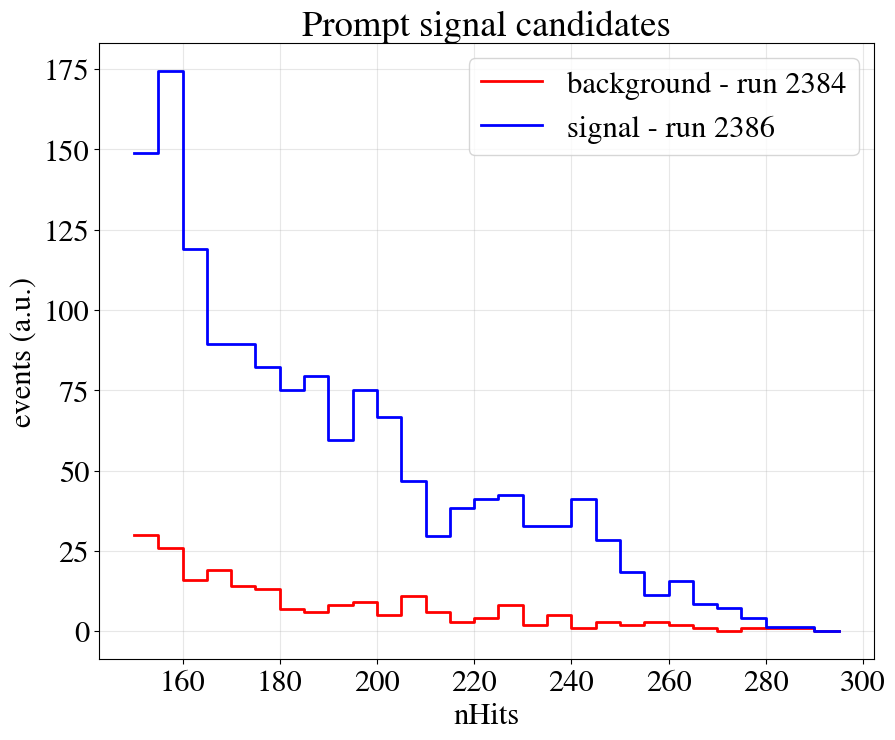

In [15]:
prompt_nhits = df.prompt_nhits.values
prompt_nhits_bkg = df_bkg.prompt_nhits.values

hist, bins_edges = np.histogram(prompt_nhits_bkg, bins=30, range=(prompt_nhits_min, prompt_nhits_max))
hist_sig, _ = np.histogram(prompt_nhits, bins = bins_edges)

plt.figure()
plt.step(bins_edges[:-1], hist, where='post', label=f'background - run {bkg_run}', color='red', lw=2)
plt.step(bins_edges[:-1], hist_sig * N_events_bkg / N_events_sig, where='post', label=f'signal - run {sig_run}', color='blue', lw=2)
plt.xlabel('nHits')
plt.ylabel('events (a.u.)')
plt.title('Prompt signal candidates')
plt.legend()
plt.grid(alpha=0.3)

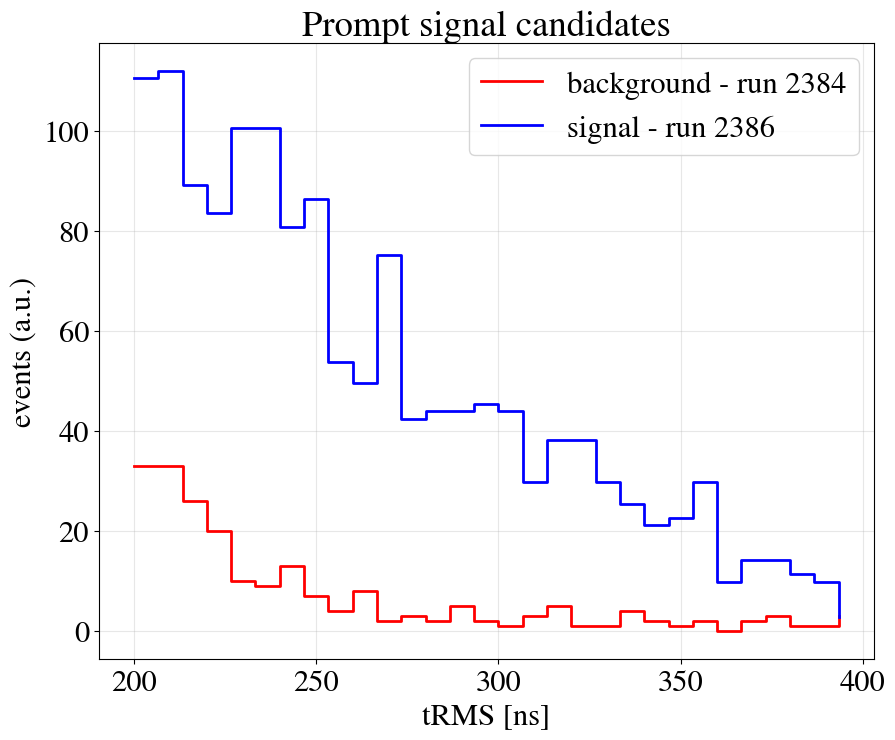

In [16]:
prompt_nhits = df.prompt_trms.values
prompt_nhits_bkg = df_bkg.prompt_trms.values

hist, bins_edges = np.histogram(prompt_nhits_bkg, bins=30, range=(prompt_t_rms_min, prompt_t_rms_max))
hist_sig, _ = np.histogram(prompt_nhits, bins = bins_edges)

plt.figure()
plt.step(bins_edges[:-1], hist, where='post', label=f'background - run {bkg_run}', color='red', lw=2)
plt.step(bins_edges[:-1], hist_sig * N_events_bkg / N_events_sig, where='post', label=f'signal - run {sig_run}', color='blue', lw=2)
plt.xlabel('tRMS [ns]')
plt.ylabel('events (a.u.)')
plt.title('Prompt signal candidates')
plt.legend()
plt.grid(alpha=0.3)

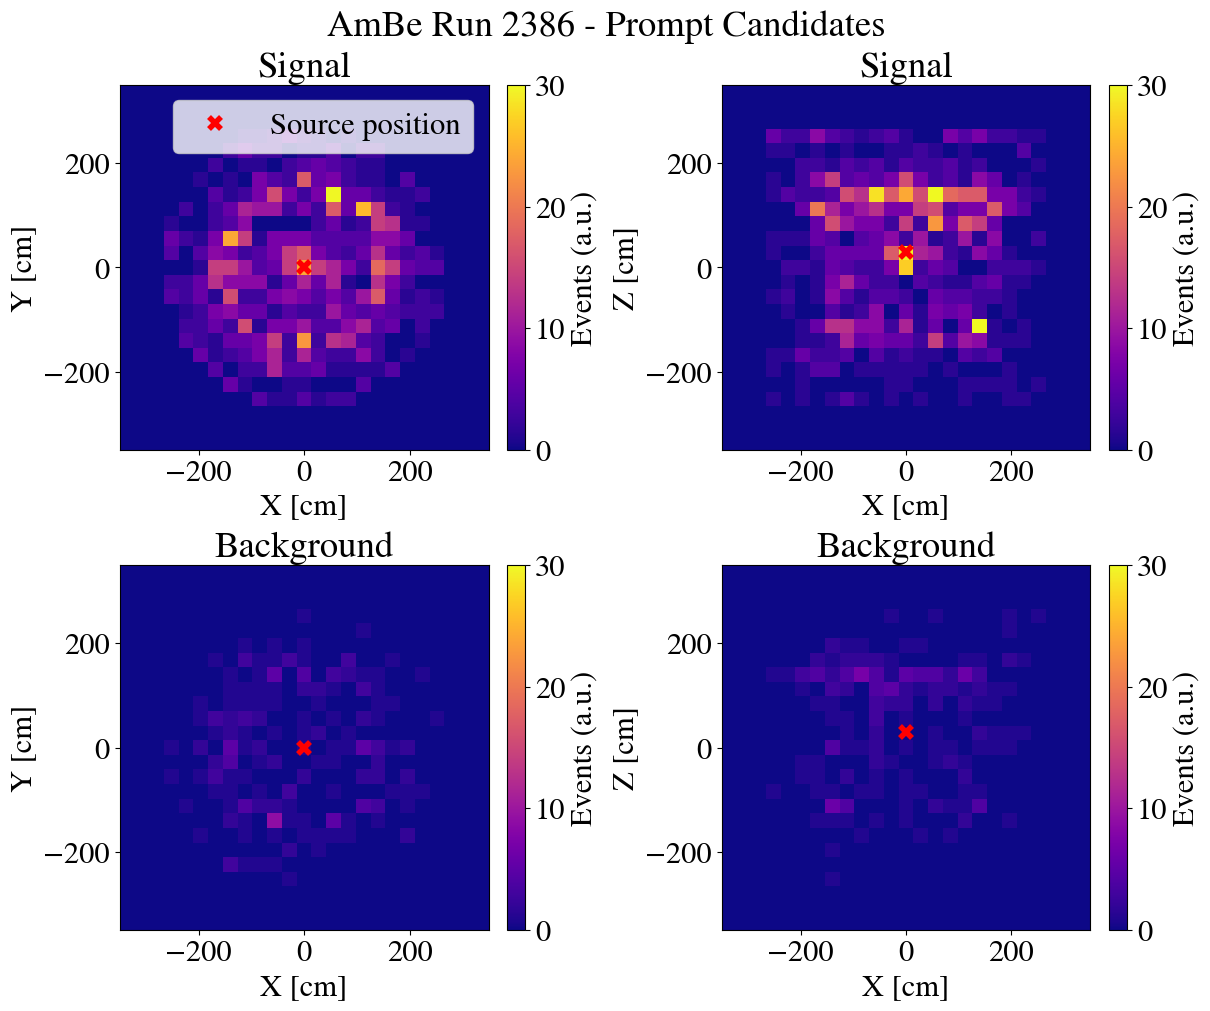

In [17]:
cols = ["prompt_x", "prompt_y", "prompt_z"]
labels = ["X [cm]", "Y [cm]", "Z [cm]"]
source_pos = {"prompt_x": pos[0], "prompt_y": pos[1], "prompt_z": pos[2]}

#N_events_bkg / N_events_sig

alpha = N_events_bkg / N_events_sig  # scale signal to background exposure

# Clean arrays
def clean(arr):
    arr = np.asarray(arr)
    return arr[np.isfinite(arr)]

sx, sy, sz = [clean(df[c].to_numpy()) for c in cols]
bx, by, bz = [clean(df_bkg[c].to_numpy()) for c in cols]

n_bins = 25

global_min = 0 
global_max = 30

# Shared bin ranges for consistency
xmin, xmax = -350, 350
ymin, ymax = -350, 350
zmin, zmax = -350, 350
xbins = np.linspace(xmin, xmax, n_bins+1)
ybins = np.linspace(ymin, ymax, n_bins+1)
zbins = np.linspace(zmin, zmax, n_bins+1)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

# SIGNAL: X vs Y
h_sig_xy, xedges, yedges, img_sig_xy = axes[0,0].hist2d(
    sx, sy, bins=[xbins, ybins], weights=np.full(sx.shape, alpha),
    cmap='plasma', vmin=global_min, vmax=global_max
)
axes[0,0].plot(source_pos["prompt_x"], source_pos["prompt_y"], 'rx', ms=8, mew=4, label='Source position')
axes[0,0].set_xlabel(labels[0]); axes[0,0].set_ylabel(labels[1])
axes[0,0].set_title("Signal")
axes[0,0].legend()
fig.colorbar(img_sig_xy, ax=axes[0,0], label="Events (a.u.)")

# SIGNAL: X vs Z
h_sig_xz, xedges, zedges, img_sig_xz = axes[0,1].hist2d(
    sx, sz, bins=[xbins, zbins], weights=np.full(sx.shape, alpha),
    cmap='plasma', vmin=global_min, vmax=global_max
)
axes[0,1].plot(source_pos["prompt_x"], source_pos["prompt_z"], 'rx', ms=8, mew=4, label='Source position')
axes[0,1].set_xlabel(labels[0]); axes[0,1].set_ylabel(labels[2])
axes[0,1].set_title("Signal")
#axes[0,1].legend()
fig.colorbar(img_sig_xz, ax=axes[0,1], label="Events (a.u.)")

# BACKGROUND: X vs Y
h_bkg_xy, xedges, yedges, img_bkg_xy = axes[1,0].hist2d(
    bx, by, bins=[xbins, ybins],
    cmap='plasma', vmin=global_min, vmax=global_max
)
axes[1,0].plot(source_pos["prompt_x"], source_pos["prompt_y"], 'rx', ms=8, mew=4,  label='Source position')
axes[1,0].set_xlabel(labels[0]); axes[1,0].set_ylabel(labels[1])
axes[1,0].set_title("Background")
#axes[1,0].legend()
fig.colorbar(img_bkg_xy, ax=axes[1,0], label="Events (a.u.)")

# BACKGROUND: X vs Z
h_bkg_xz, xedges, zedges, img_bkg_xz = axes[1,1].hist2d(
    bx, bz, bins=[xbins, zbins],
    cmap='plasma', vmin=global_min, vmax=global_max
)
axes[1,1].plot(source_pos["prompt_x"], source_pos["prompt_z"], 'rx', ms=8, mew=4, label='Source position')
axes[1,1].set_xlabel(labels[0]); axes[1,1].set_ylabel(labels[2])
axes[1,1].set_title("Background")
#axes[1,1].legend()
fig.colorbar(img_bkg_xz, ax=axes[1,1], label="Events (a.u.)")

fig.suptitle(f"AmBe Run {sig_run} - Prompt Candidates")
plt.show()

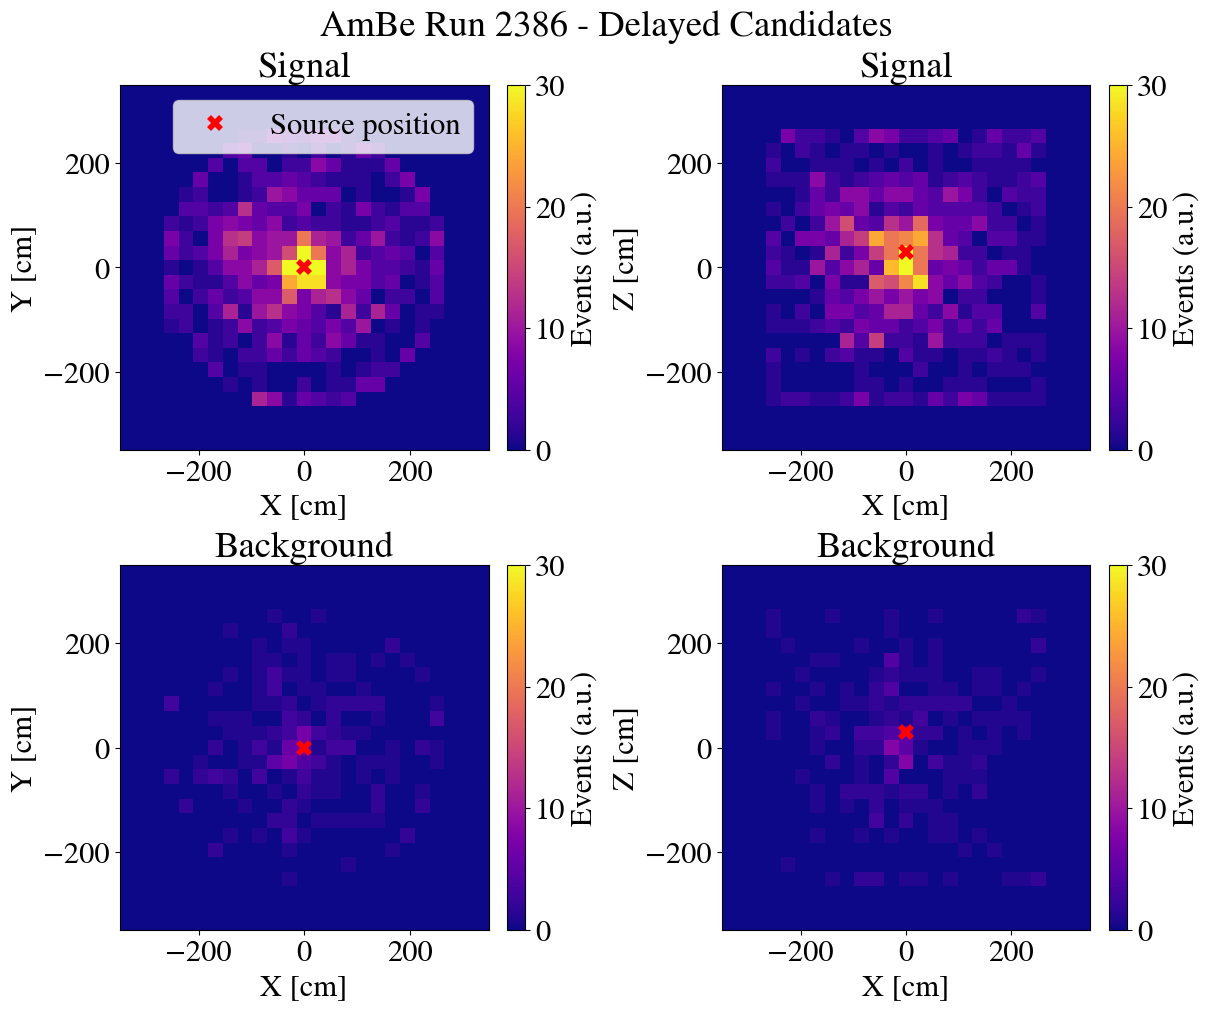

In [18]:
cols = ["delayed_x", "delayed_y", "delayed_z"]
labels = ["X [cm]", "Y [cm]", "Z [cm]"]
source_pos = {"prompt_x": pos[0], "prompt_y": pos[1], "prompt_z": pos[2]}

alpha = N_events_bkg / N_events_sig   # scale signal to background exposure

# Clean arrays
def clean(arr):
    arr = np.asarray(arr)
    return arr[np.isfinite(arr)]

sx, sy, sz = [clean(df[c].to_numpy()) for c in cols]
bx, by, bz = [clean(df_bkg[c].to_numpy()) for c in cols]

n_bins = 25

global_min = 0 
global_max = 30

# Shared bin ranges for consistency
xmin, xmax = -350, 350
ymin, ymax = -350, 350
zmin, zmax = -350, 350
xbins = np.linspace(xmin, xmax, n_bins+1)
ybins = np.linspace(ymin, ymax, n_bins+1)
zbins = np.linspace(zmin, zmax, n_bins+1)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

# SIGNAL: X vs Y
h_sig_xy, xedges, yedges, img_sig_xy = axes[0,0].hist2d(
    sx, sy, bins=[xbins, ybins], weights=np.full(sx.shape, alpha),
    cmap='plasma', vmin=global_min, vmax=global_max
)
axes[0,0].plot(source_pos["prompt_x"], source_pos["prompt_y"], 'rx', ms=8, mew=4, label='Source position')
axes[0,0].set_xlabel(labels[0]); axes[0,0].set_ylabel(labels[1])
axes[0,0].set_title("Signal")
axes[0,0].legend()
fig.colorbar(img_sig_xy, ax=axes[0,0], label="Events (a.u.)")

# SIGNAL: X vs Z
h_sig_xz, xedges, zedges, img_sig_xz = axes[0,1].hist2d(
    sx, sz, bins=[xbins, zbins], weights=np.full(sx.shape, alpha),
    cmap='plasma', vmin=global_min, vmax=global_max
)
axes[0,1].plot(source_pos["prompt_x"], source_pos["prompt_z"], 'rx', ms=8, mew=4, label='Source position')
axes[0,1].set_xlabel(labels[0]); axes[0,1].set_ylabel(labels[2])
axes[0,1].set_title("Signal")
#axes[0,1].legend()
fig.colorbar(img_sig_xz, ax=axes[0,1], label="Events (a.u.)")

# BACKGROUND: X vs Y
h_bkg_xy, xedges, yedges, img_bkg_xy = axes[1,0].hist2d(
    bx, by, bins=[xbins, ybins],
    cmap='plasma', vmin=global_min, vmax=global_max
)
axes[1,0].plot(source_pos["prompt_x"], source_pos["prompt_y"], 'rx', ms=8, mew=4,  label='Source position')
axes[1,0].set_xlabel(labels[0]); axes[1,0].set_ylabel(labels[1])
axes[1,0].set_title("Background")
#axes[1,0].legend()
fig.colorbar(img_bkg_xy, ax=axes[1,0], label="Events (a.u.)")

# BACKGROUND: X vs Z
h_bkg_xz, xedges, zedges, img_bkg_xz = axes[1,1].hist2d(
    bx, bz, bins=[xbins, zbins],
    cmap='plasma', vmin=global_min, vmax=global_max
)
axes[1,1].plot(source_pos["prompt_x"], source_pos["prompt_z"], 'rx', ms=8, mew=4, label='Source position')
axes[1,1].set_xlabel(labels[0]); axes[1,1].set_ylabel(labels[2])
axes[1,1].set_title("Background")
#axes[1,1].legend()
fig.colorbar(img_bkg_xz, ax=axes[1,1], label="Events (a.u.)")

fig.suptitle(f"AmBe Run {sig_run} - Delayed Candidates")
plt.show()

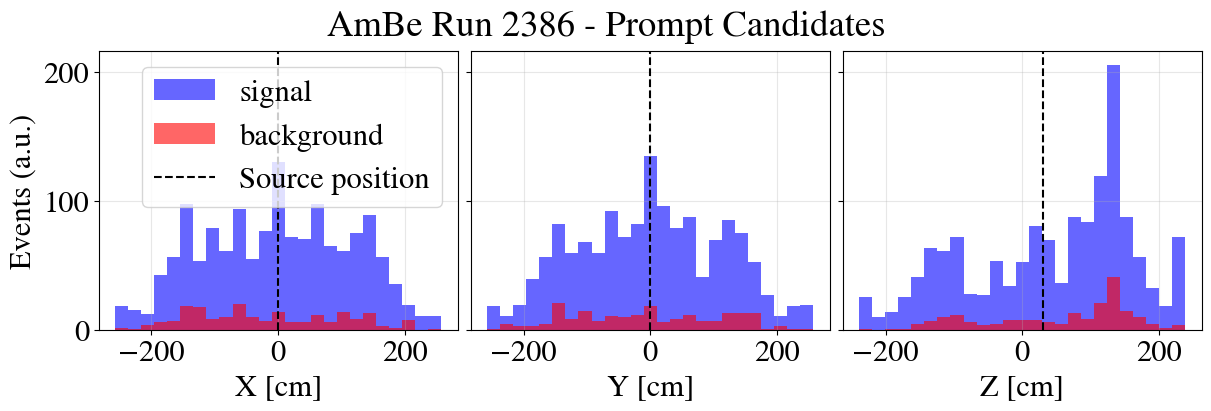

In [19]:
cols = ["prompt_x", "prompt_y", "prompt_z"]
labels = ["X [cm]", "Y [cm]", "Z [cm]"]

source_pos = {"prompt_x": pos[0], "prompt_y": pos[1], "prompt_z": pos[2]}

alpha = N_events_bkg / N_events_sig  # scale signal to background exposure

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True, constrained_layout=True)

for ax, col, label in zip(axes, cols, labels):
    # Drop non-finite
    s = df[col].to_numpy()
    b = df_bkg[col].to_numpy()
    s = s[np.isfinite(s)]
    b = b[np.isfinite(b)]

    # Common bins from combined range
    xmin = np.min([s.min(), b.min()]) if len(s) and len(b) else (s.min() if len(s) else b.min())
    xmax = np.max([s.max(), b.max()]) if len(s) and len(b) else (s.max() if len(s) else b.max())
    bins = np.linspace(xmin, xmax, 26)  # 50 bins

    # Histograms: scale signal counts by alpha via weights
    ax.hist(s, bins=bins, weights=np.full(s.shape, alpha), color="blue", alpha=0.6, label=f'signal')
    ax.hist(b, bins=bins, color="red", alpha=0.6, label=f'background')

    # Source marker line
    vline = source_pos[col]
    ax.axvline(vline, color="k", linestyle="--", linewidth=1.5, label="Source position")

    ax.set_xlabel(label)
    ax.grid(alpha=0.3)
    if(col =='prompt_x'):
        ax.legend()

axes[0].set_ylabel("Events (a.u.)")
fig.suptitle(f"AmBe Run {sig_run} - Prompt Candidates")
plt.show()


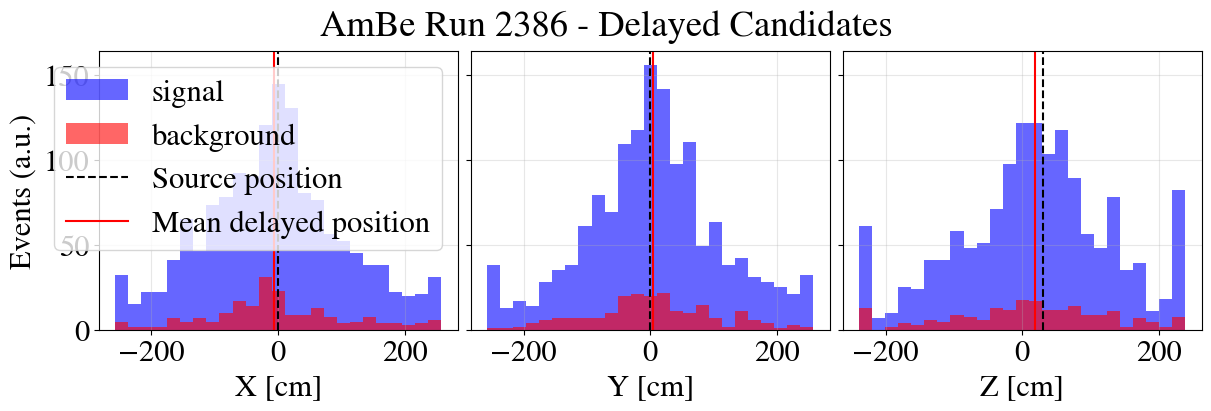

In [20]:
cols = ["delayed_x", "delayed_y", "delayed_z"]
labels = ["X [cm]", "Y [cm]", "Z [cm]"]

source_pos = {"delayed_x": pos[0], "delayed_y": pos[1], "delayed_z": pos[2]}
mean = {"delayed_x": mean_x, "delayed_y": mean_y, "delayed_z": mean_z}

alpha = N_events_bkg / N_events_sig  # scale signal to background exposure

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True, constrained_layout=True)

for ax, col, label in zip(axes, cols, labels):
    # Drop non-finite
    s = df[col].to_numpy()
    b = df_bkg[col].to_numpy()
    s = s[np.isfinite(s)]
    b = b[np.isfinite(b)]

    # Common bins from combined range
    xmin = np.min([s.min(), b.min()]) if len(s) and len(b) else (s.min() if len(s) else b.min())
    xmax = np.max([s.max(), b.max()]) if len(s) and len(b) else (s.max() if len(s) else b.max())
    bins = np.linspace(xmin, xmax, 26)  # 50 bins

    # Histograms: scale signal counts by alpha via weights
    ax.hist(s, bins=bins, weights=np.full(s.shape, alpha), color="blue", alpha=0.6, label=f'signal')
    ax.hist(b, bins=bins, color="red", alpha=0.6, label=f'background')

    # Source marker line
    vline = source_pos[col]
    ax.axvline(vline, color="k", linestyle="--", linewidth=1.5, label="Source position")
    vline2 = mean[col]
    ax.axvline(vline2, color="r", linestyle="-", linewidth=1.5, label="Mean delayed position")

    ax.set_xlabel(label)
    ax.grid(alpha=0.3)
    if(col =='delayed_x'):
        ax.legend()

axes[0].set_ylabel("Events (a.u.)")
fig.suptitle(f"AmBe Run {sig_run} - Delayed Candidates")
plt.show()

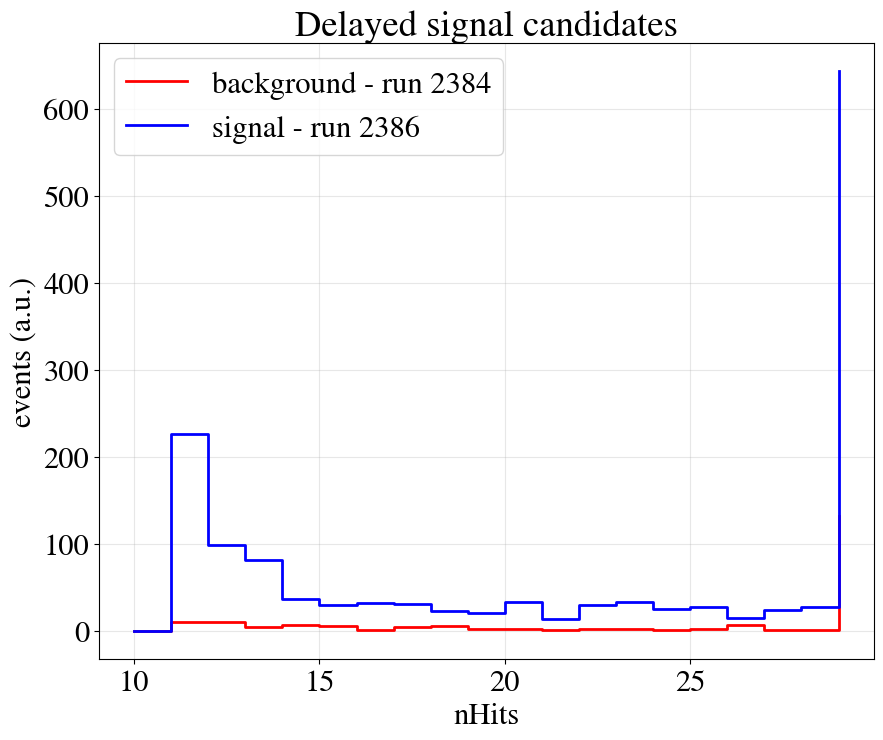

In [21]:
prompt_nhits = df.delayed_nhits.values
prompt_nhits_bkg = df_bkg.delayed_nhits.values

hist, bins_edges = np.histogram(prompt_nhits_bkg, bins=20, range=(delayed_nhits_min, delayed_nhits_max))
hist_sig, _ = np.histogram(prompt_nhits, bins = bins_edges)

plt.figure()
plt.step(bins_edges[:-1], hist, where='post', label=f'background - run {bkg_run}', color='red', lw=2)
plt.step(bins_edges[:-1], hist_sig * N_events_bkg / N_events_sig, where='post', label=f'signal - run {sig_run}', color='blue', lw=2)
plt.xlabel('nHits')
plt.ylabel('events (a.u.)')
plt.title('Delayed signal candidates')
plt.legend()
plt.grid(alpha=0.3)

In [22]:
df

,prompt_id,prompt_nhits,prompt_time,prompt_trms,prompt_x,prompt_y,prompt_z,delayed_time,delayed_nhits,delayed_x,delayed_y,delayed_z,prompt_r,delayed_r,DeltaR,DeltaT
0,1,215,5.430911e+09,224.754683,27.825008,-26.006439,105.636604,5.431047e+09,29,-152.717529,56.698921,62.029957,112.292734,174.313301,62.020567,135.640446
1,0,198,5.464951e+09,212.441503,-115.993393,-205.113663,158.634613,5.464952e+09,13,-50.269352,-143.142410,15.523750,284.061652,152.504899,131.556753,1.514243
2,1,262,5.558531e+09,200.336731,145.636688,30.866497,-108.289581,5.558627e+09,14,-165.267883,41.123940,-114.201630,184.090790,205.052832,20.962042,96.326377
3,0,201,5.563682e+09,268.970094,-248.441711,68.455147,-189.578613,5.563807e+09,29,-153.655777,15.722279,-155.748932,319.920993,219.351357,100.569636,124.995384
4,0,261,5.563807e+09,259.880346,169.671234,132.629456,-235.157486,5.563830e+09,22,-14.430691,-19.918678,3.757387,318.869791,24.882053,293.987738,23.004705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,0,158,1.345804e+12,215.877825,-30.043184,-173.318970,-186.419388,1.345804e+12,29,-12.394491,-32.973236,10.550446,256.308889,36.771859,219.537030,39.526707
1026,0,195,1.345821e+12,247.079598,-137.899429,61.357273,89.869972,1.345821e+12,18,60.208515,-250.567993,238.848557,175.663256,351.365931,175.702675,100.932104
1027,0,157,1.345841e+12,227.313122,15.948623,3.467802,190.783569,1.345841e+12,29,-160.072937,-91.505180,98.316521,191.480429,208.956171,17.475742,129.801440
1028,0,187,1.345914e+12,211.270669,-3.103086,192.466690,-100.797546,1.345914e+12,29,73.386917,-49.968102,-73.463692,217.285990,115.236126,102.049863,22.306115


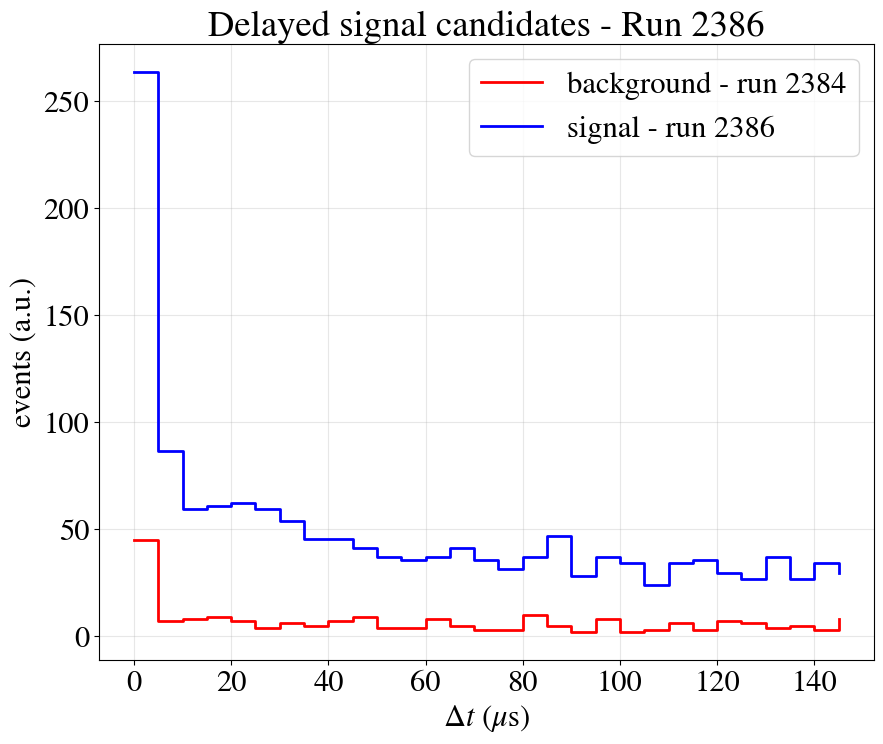

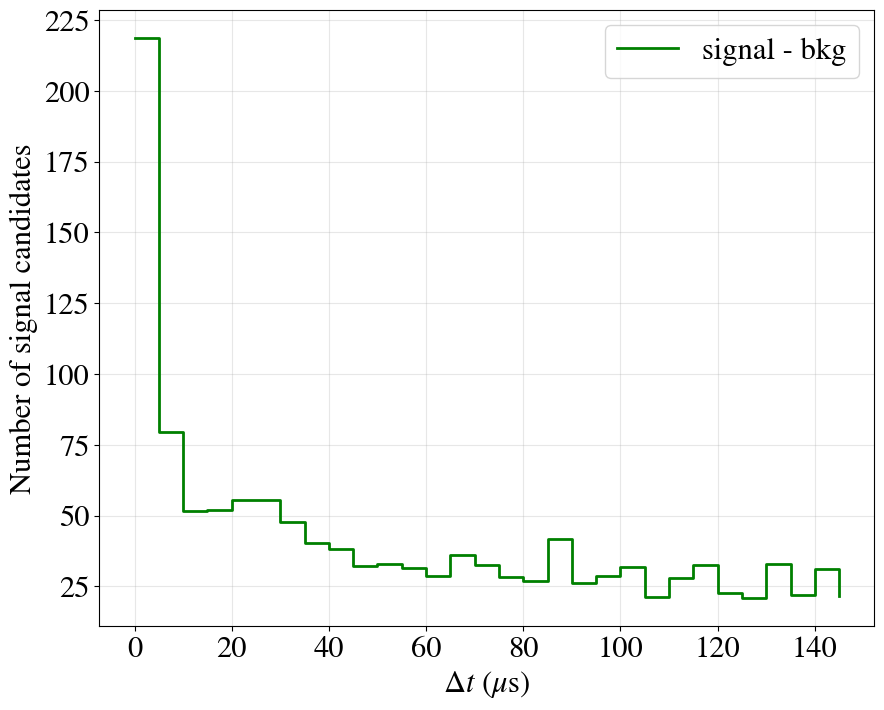

Ajuste: A = 64.98, tau = 107.38


/tmp/ipykernel_22718/1218853108.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_fit, exp_func(x_fit, *popt), 'r-', label=f'Fit data: A·exp(-x/τ), τ ≈ {tau_fit:.0f} ± {tau_err:.0f} μs', color="black")


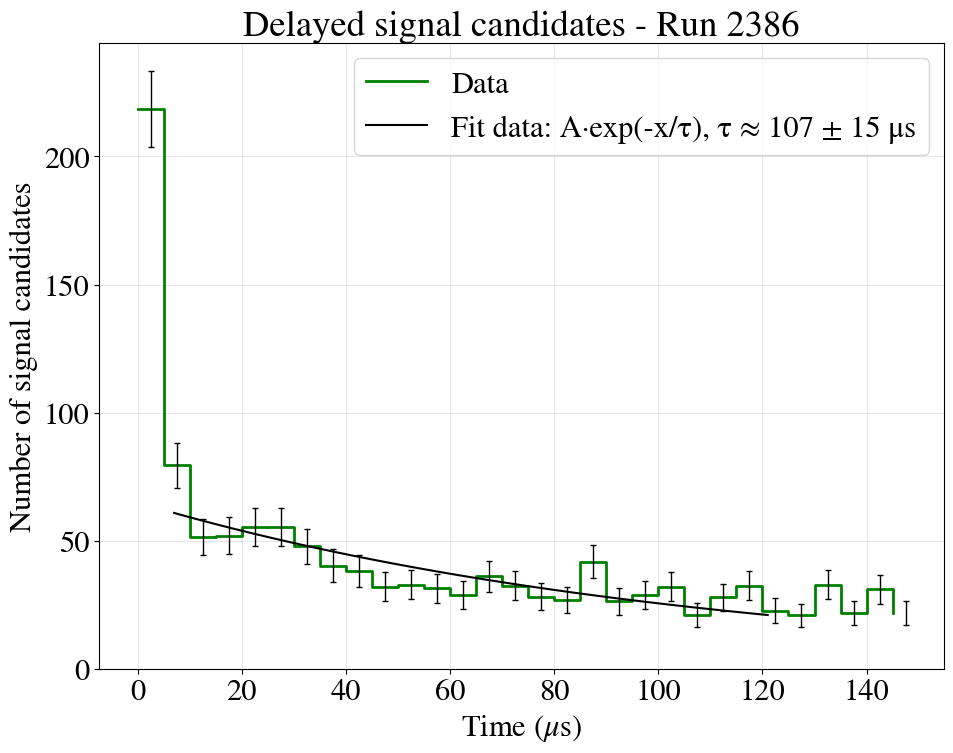

In [23]:
prompt_nhits = df.DeltaT.values
prompt_nhits_bkg = df_bkg.DeltaT.values

hist, bins_edges = np.histogram(prompt_nhits_bkg, bins=30, range=(0, 150))
hist_sig, _ = np.histogram(prompt_nhits, bins = bins_edges)

plt.figure()
plt.step(bins_edges[:-1], hist, where='post', label=f'background - run {bkg_run}', color='red', lw=2)
plt.step(bins_edges[:-1], hist_sig * N_events_bkg / N_events_sig, where='post', label=f'signal - run {sig_run}', color='blue', lw=2)
plt.xlabel(r'$\Delta t$ ($\mu$s)')
plt.ylabel('events (a.u.)')
plt.title(f'Delayed signal candidates - Run {sig_run}')
plt.legend()
plt.grid(alpha=0.3)

plt.figure()
plt.step(bins_edges[:-1], hist_sig*N_events_bkg/N_events_sig - hist, where='post', linewidth=2, color='green', label=f'signal - bkg')
plt.xlabel(r'$\Delta t$ ($\mu$s)')
plt.ylabel('Number of signal candidates')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

bin_centers = 0.5 * (bins_edges[:-1] + bins_edges[1:])
values = hist_sig * N_events_bkg / N_events_sig - hist

np.savez(f'/scratch/halmazan/WCTE/files/data/AmBeCandidates/histograms_run{sig_run}.npz', deltat=values, bins_deltat=bin_centers)

bin_centers = (bins_edges[:-1] + bins_edges[1:]) / 2  
data = hist_sig*N_events_bkg/N_events_sig  - hist
errors = np.sqrt(data)


popt, pcov = curve_fit(exp_func, bin_centers[1:-6], data[1:-6], p0=(max(data), 500))

# popt contiene los parámetros A y tau
A_fit, tau_fit = popt
A_err, tau_err = np.sqrt(np.diag(pcov))  # Error en A y tau

print(f"Ajuste: A = {A_fit:.2f}, tau = {tau_fit:.2f}")

plt.figure()
plt.step(bins_edges[:-1], data, where='post', linewidth=2, label='Data', color='green')
plt.errorbar(bin_centers, data, yerr=errors, fmt='none', ecolor='black', elinewidth=1, capsize=2)
x_fit = np.arange(int(bin_centers[1]), int(bin_centers[-6]), 1)
plt.plot(x_fit, exp_func(x_fit, *popt), 'r-', label=f'Fit data: A·exp(-x/τ), τ ≈ {tau_fit:.0f} ± {tau_err:.0f} μs', color="black")
plt.xlabel(r'Time ($\mu$s)')
plt.ylabel('Number of signal candidates')
plt.grid(alpha=0.3)
plt.title(f'Delayed signal candidates - Run {sig_run}')
plt.legend()
plt.tight_layout()
plt.ylim(bottom = 0)
plt.show()


Mean value: 67.16243876923858


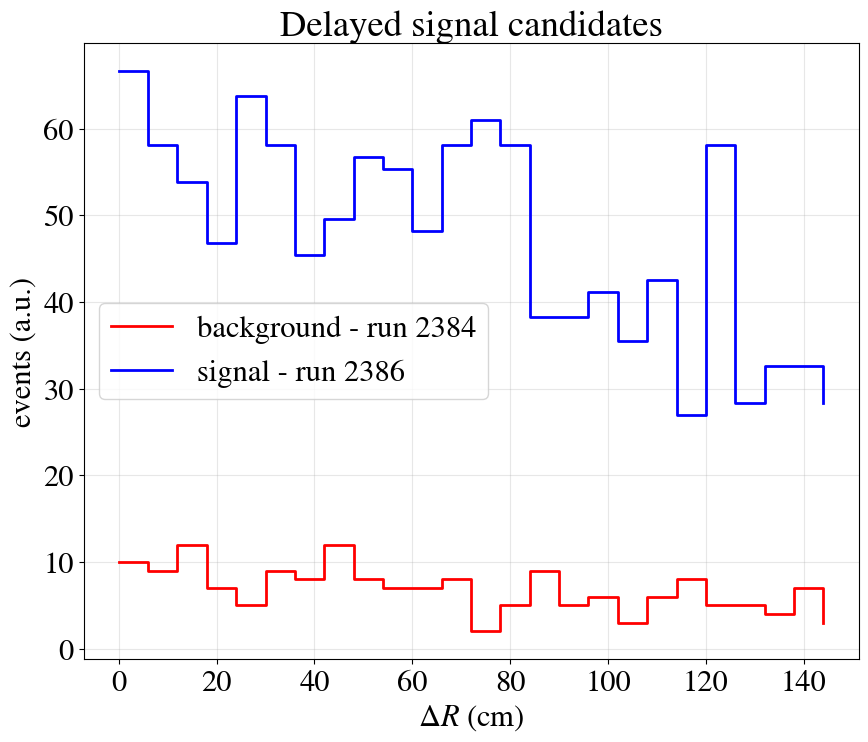

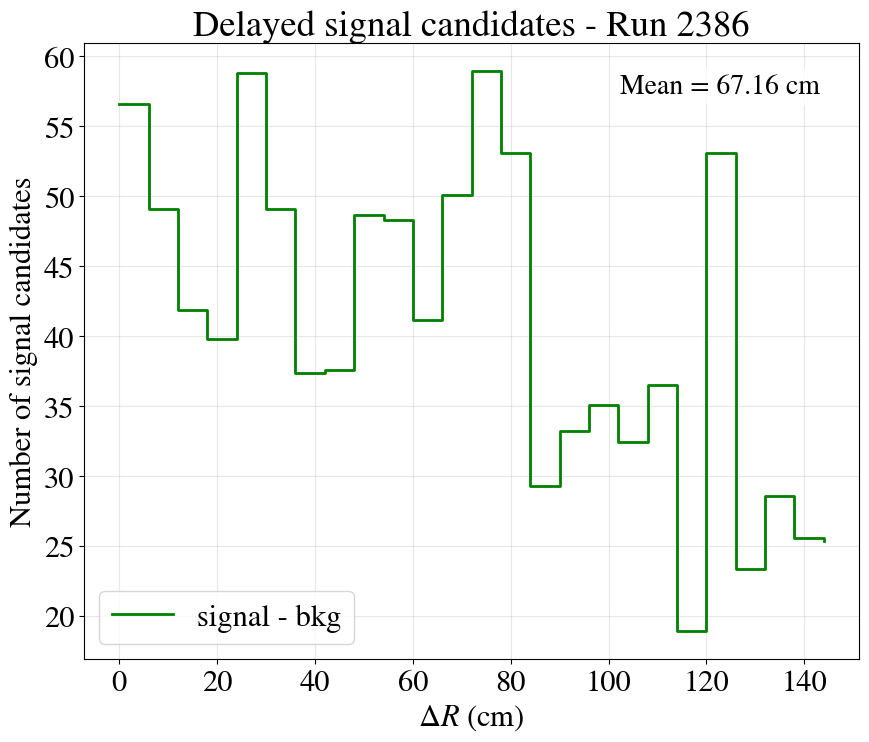

In [24]:
prompt_nhits = df.DeltaR.values
prompt_nhits_bkg = df_bkg.DeltaR.values

hist, bins_edges = np.histogram(prompt_nhits_bkg, bins=25, range=(0, 150))
hist_sig, _ = np.histogram(prompt_nhits, bins = bins_edges)

plt.figure()
plt.step(bins_edges[:-1], hist, where='post', label=f'background - run {bkg_run}', color='red', lw=2)
plt.step(bins_edges[:-1], hist_sig * N_events_bkg / N_events_sig, where='post', label=f'signal - run {sig_run}', color='blue', lw=2)
plt.xlabel(r'$\Delta R$ (cm)')
plt.ylabel('events (a.u.)')
plt.title(f'Delayed signal candidates')
plt.legend()
plt.grid(alpha=0.3)

bin_centers = 0.5 * (bins_edges[:-1] + bins_edges[1:])
values = hist_sig * N_events_bkg / N_events_sig - hist

data = dict(np.load(f'/scratch/halmazan/WCTE/files/data/AmBeCandidates/histograms_run{sig_run}.npz'))
data['deltaR'] = values
data['bins_deltaR'] = bin_centers
np.savez(f'/scratch/halmazan/WCTE/files/data/AmBeCandidates/histograms_run{sig_run}.npz', **data)



mean_val = np.sum(bin_centers * values) / np.sum(values)
print("Mean value:", mean_val)

plt.figure()
plt.step(bins_edges[:-1], hist_sig*N_events_bkg/N_events_sig - hist, where='post', linewidth=2, color='green', label=f'signal - bkg')
plt.xlabel(r'$\Delta R$ (cm)')
plt.ylabel('Number of signal candidates')
plt.title(f'Delayed signal candidates - Run {sig_run}')
plt.grid(alpha=0.3)
plt.legend()
plt.text(
    0.95, 0.95, 
    f"Mean = {mean_val:.2f} cm", 
    ha='right', va='top', 
    transform=plt.gca().transAxes,  # relative coords (0–1)
    fontsize=20, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)
plt.show()

In [60]:
np.mean(df.DeltaT.values), np.mean(df_bkg.DeltaT.values), np.mean(df.DeltaR.values), np.mean(df_bkg.DeltaR.values)

(np.float64(54.97989494164194),
 np.float64(45.63207961026906),
 np.float64(91.7444078927841),
 np.float64(92.29205000807896))